# Análise Trabalho T9 

In [1]:
kfahsdfasdoºf

NameError: name 'kfahsdfasdoof' is not defined

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.optimize as spo
import sympy as sp
np.set_printoptions(suppress=True, linewidth= 500)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Formatação de gráfico 

Fica aqui o código genérico para fazer um gráfico maravilhoso 

##### Código para mudar 

In [2]:
# --- Formatação da figura ---
cm          = 1/2.54  # centimeters in inches
figsize     = ( 12*cm, 10*cm )
dpi         = 100

# --- Texto que apareça no gráfico ---
fontsize        = 8
legend_label    = "Pontos Experimentais"
xlabel          = ""
ylabel          = "$\|\epsilon| $(mV)"

# --- Formação dos pontos ---
marker_type = "."
markersize  = 2.5
color_mk    = "lime"


# --- formatação da escala do gráfico ---
xticks      = np.linspace( - 1 , 1 , 10 )
yticks      = np.linspace( -20 , 20 , 9)

# --- Transparência da grid ---
alpha_grid = 0.5 

# --- Formatação barras de erro --- 
color_bars    = "k"
alpha_bars    = 0.5
thickness     = 1 
head_size     = 1 
head_thick    = 0.2 

# --- Informação para guardar a imagem ---
fig_name = "fig1" #sem o png!


# --- data para dar plot ---
#data_x = ...
#data_y = ...
#u x    = ...
#u_y    = ...

### Funções

In [3]:
def makeplot(data, dt_label, color_mk, *errors, bars=False,):
    data_x, data_y = data[0], data[1]
    fig , ax = plt.subplots( figsize = figsize, dpi = dpi  ) 
    ax.legend( fontsize = fontsize)
    ax.set_xlabel( xlabel , fontsize = fontsize )
    ax.set_ylabel( ylabel , fontsize = fontsize )
    if ticks:
        ax.set_xticks( xticks )
        ax.set_yticks( yticks )
        ax.set_xlim( xticks[0] , xticks[-1])
        ax.set_ylim( yticks[0] , yticks[-1])
    plt.grid( alpha = alpha_grid )
    plot_data = ax.plot( data_x , data_y , marker_type ,
                    label      = dt_label , 
                    markersize = markersize )
    plot_data[0].set_color(color_mk )
    if bars:
        errorbar = plt.errorbar( data_x , data_y ,
                                yerr       = errors[0][1] ,
                                xerr       = errors[0][0] , 
                                color      = color_bars ,
                                ls         ='' , 
                                alpha      = alpha_bars ,
                                elinewidth = thickness,
                                capsize    = head_size , 
                                capthick   = 0.2 )
    plt.legend( fontsize = fontsize )
    plt.tight_layout()
    return fig, ax

def add_points(data, dt_label, color_mk, figure,*errors, bars= False):
    data_x, data_y = data[0], data[1]
    fig, ax = figure[0], figure[1]
    plot_data = ax.plot( data_x , data_y , marker_type ,
                    label      = dt_label , 
                    markersize = markersize )
    plot_data[0].set_color(color_mk )
    if bars:
        errorbar = plt.errorbar( data_x , data_y ,
                                yerr       = errors[0][1] ,
                                xerr       = errors[0][0] , 
                                color      = color_bars ,
                                ls         ='' , 
                                alpha      = alpha_bars ,
                                elinewidth = thickness,
                                capsize    = head_size , 
                                capthick   = 0.2 )
    ax.legend( fontsize = fontsize )

def get_coef( x , y , f_fit , coef0 ):
    result = spo.curve_fit( f_fit , x , y , p0 = coef0 )
    return result[ 0 ]

def add_fit( ax , x , coef , f_fit , label="Fit",linestyle = "k--"):
    y_fit     = f_fit( x ,*coef )
    linewidth = 1
    alpha     = 0.5 
    if label != False:
        ax.plot( x , y_fit , linestyle , label = label, linewidth = linewidth , alpha = alpha  )
        ax.legend(  fontsize = fontsize )
    else:
         ax.plot( x , y_fit , linestyle , linewidth = linewidth , alpha = alpha )
    
    return ax , y_fit

def add_residues( x , y_fit , y , color, in_fig , *args ):
    if not in_fig: 
        fig , ax = plt.subplots( figsize = (figsize))
        ax.set_xlabel( xlabel )
        ax.set_ylabel( "Resíduos" )
        ax.legend( fontsize = 15)
    
    else : 
        fig = args[ 0 ]
        ax = args[ 1 ]
        loc= args[2]
        ax = inset_axes(ax, width="30%", height="30%", loc=loc)
    
    res       = y - y_fit
    
    global max_res
    global min_res
    max_res, min_res = max(max_res, np.max(res)), min(min_res,np.min(res))
    ax.scatter( x , res ,color = color, marker='.' )
    if ticks:
        ax.set_xticks( xticks )
        ax.set_yticks( yticks )
        ax.set_xlim( ( xticks[0] , xticks[-1]) )
        ax.set_ylim( ( yticks[0] , yticks[-1]) )
    ax.grid(True)
    ax.set_title("Resíduos")
    if in_fig:
        return ax     
    return fig , ax  

colors=['blue', 'orange', 'green', 'magenta', 'purple']
max_res, min_res = 0, 0
# para guardar a imagem 
#fig.savefig( fig_name + ".png" )

In [32]:
def estimate_parameters( x , y , ux , uy , coef0 , f_fit,
                         get_coef = get_coef  ,
                         N = 100 ):
    """
    ---
    Usa métodos de Monte-Carlo para simular pontos
    e assim estimar qual o valor das incertezas dos 
    coeficientes
    ---
    :x        : abcissas experimentais 
    :y        : ordenas experimentais 
    :ux       : incertezas abcissas experimentais 
    :uy       : incertezas ordenadas experimentais
    :coef0    : primeira estimativa dos coeficientes
    :get_coef : função que calcula os parametros
    :f_fit    : função que modela os nossos dados
    :N        : número de pontos que vão ser simulados
    """
    
    n_coef   = len( coef0 )
    M        = len( x )
    coef_arr = np.empty( ( N , n_coef ) )
    
    
    x_sim = x + ux * np.random.normal( loc = 0 , scale = 1 , size = ( N , M ) )
    y_sim = y + uy * np.random.normal( loc = 0 , scale = 1 , size = ( N , M ) )
    
    for i in range( N ):
        coef_arr[ i ] = get_coef( x_sim[ i ] , y_sim[ i ] , f_fit , coef0 )
        
    return np.mean( coef_arr , axis = 0 ) , np.std( coef_arr , axis = 0 ) , coef_arr

## Primeira Parte 

### Parte A

#### Dados

In [4]:
data = np.genfromtxt("CSVs/T9_1_A_NT.csv", delimiter = ",", skip_header=1)
# --- data para dar plot ---
data_NT = np.transpose(data[:, 0:2])
erros_NT = np.transpose(data[:, 2:4])
data =  np.genfromtxt("CSVs/T9_1_A_T.csv", delimiter = ",", skip_header=1)
data_T = np.transpose(data[:, 0:2])
erros_T = np.transpose(data[:, 2:4])

In [5]:
# --- Formatação da figura ---
cm          = 1/2.54  # centimeters in inches
figsize     = ( 12*cm, 10*cm )
dpi         = 100

# --- Texto que apareça no gráfico ---
fontsize        = 12
title           = "Eixo máximo"
xlabel          = r"$\theta_p$ (º)"
ylabel          = "$V_{pp}$(mV)"

# --- Formação dos pontos ---
marker_type = "o"
markersize  = 2.5

# --- formatação da escala do gráfico ---
ticks = False
if ticks:
    xticks      = np.linspace( - 95 , 95 , 10 )
    yticks      = np.linspace( 70 , 275 , 10)

# --- Transparência da grid ---
alpha_grid = 0.5 

# --- Formatação barras de erro --- 
color_bars    = "k"
alpha_bars    = 0.5
thickness     = 1 
head_size     = 1 
head_thick    = 0.2 

# --- Informação para guardar a imagem ---
fig_name = "fig1" #sem o png!


#### Gráficos

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Eixo máximo')

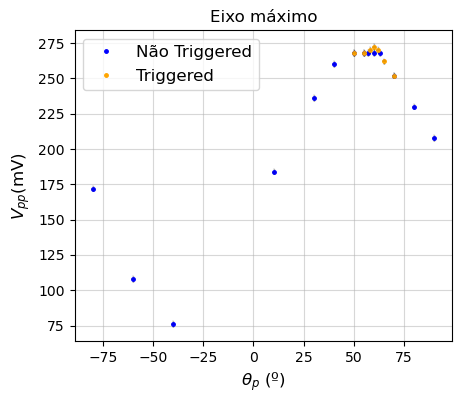

In [6]:
fig, ax=makeplot(data_NT, "Não Triggered", colors[0], erros_NT, bars = True)
add_points(data_T, "Triggered", colors[1], [fig, ax], erros_T, bars =True)
plt.title(title)

#fig.savefig( fig_name + ".png" )

In [7]:
thetaP = 60 # fixar thetaP para o resto da análise

### Parte B

#### Dados

In [36]:
data = np.genfromtxt("CSVs/T9_1_B_NT.csv", delimiter = ",", skip_header=1)
# --- data para dar plot ---
data_NT = np.transpose(data[:, 0:2])
erros_NT = np.transpose(data[:, 2:4])

data_NT_bad = np.genfromtxt("CSVs/T9_1_B_NT_errado.csv", delimiter = ",", skip_header=1)
data_NT_bad = np.transpose(data[:, 0:2])
erros_NT_bad = np.transpose(data[:, 2:4])

data =  np.genfromtxt("CSVs/T9_1_B_T.csv", delimiter = ",", skip_header=1)
data_T = np.transpose(data[:, 0:2])
erros_T = np.transpose(data[:, 2:4])

In [37]:
# --- Formatação da figura ---
cm          = 1/2.54  # centimeters in inches
figsize     = ( 12*cm, 10*cm )
dpi         = 100

# --- Texto que apareça no gráfico ---
fontsize        = 12
title           = "Lei de Mallus"
xlabel          = r"$\theta_a$ (º)"
ylabel          = "$V_{pp}$(mV)"

# --- Formação dos pontos ---
marker_type = "o"
markersize  = 2.5

# --- formatação da escala do gráfico ---
ticks = False
if ticks:
    xticks      = np.linspace( - 95 , 95 , 10 )
    yticks      = np.linspace( 70 , 275 , 10)

# --- Transparência da grid ---
alpha_grid = 0.5 

# --- Formatação barras de erro --- 
color_bars    = "k"
alpha_bars    = 0.5
thickness     = 1 
head_size     = 1 
head_thick    = 0.2 

# --- Informação para guardar a imagem ---
fig_name = "fig2" #sem o png!

#### Gráficos

Lei de Malus , com constantes por determinar 

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Lei de Mallus')

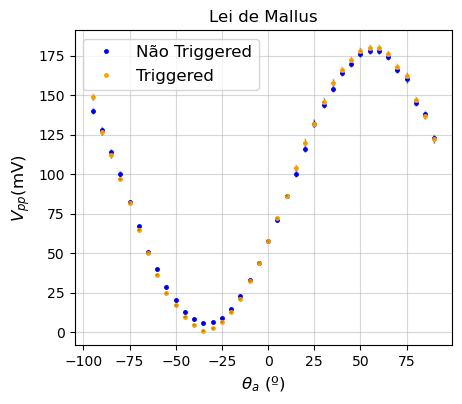

In [38]:
fig, ax=makeplot(data_NT, "Não Triggered", colors[0], erros_NT, bars = True)
add_points(data_T, "Triggered", colors[1], [fig, ax], erros_T, bars =True)
plt.title(title)

coeficientes: 
 [171.70141461   5.73923969  -6.3414209 ] 
 [177.75715266   2.60705733  -6.34819214] 

incertezas estimadas relativas: 
 [31.14610988 15.56537355  1.21589155] 
 [28.42792537 14.20489267  1.1484583 ]


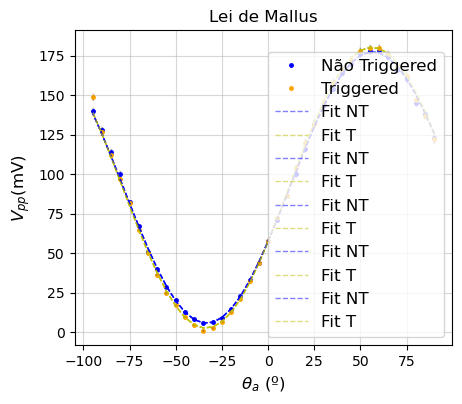

In [45]:
def mallus(A, P0,b,c):
    return P0* np.cos(c+ np.radians(thetaP-A))**2+b

coefs_NT = get_coef( data_NT[0] , data_NT[1] , mallus , [1.75, 0,0] )
coefs_T = get_coef( data_T[0] , data_T[1] , mallus , [1.75, 0,0] )




N = int( 1e4 )

coefs_NT_est , std_NT_est,coefs_NT_arr  = estimate_parameters( data_NT[0] , data_NT[1],
                                                               erros_NT[0] , erros_NT[1] ,
                                                               [ 1.75 , 0 , 0 ],
                                                               mallus , 
                                                               get_coef = get_coef ,
                                                               N = N )

coefs_T_est , std_T_est,coefs_T_arr  = estimate_parameters( data_T[0] , data_NT[1],
                                                               erros_T[0] , erros_T[1] ,
                                                               [ 1.75 , 0 , 0 ],
                                                               mallus , 
                                                               get_coef = get_coef ,
                                                               N = N )

print("coeficientes: \n", coefs_NT, '\n', coefs_T ,"\n")

print( "incertezas estimadas relativas: \n",std_NT_est,'\n',std_T_est )






add_fit(ax, data_NT[0], coefs_NT, mallus, label="Fit NT", linestyle = "b--")
add_fit(ax, data_T[0], coefs_T, mallus, label = "Fit T", linestyle='y--')
fig

No handles with labels found to put in legend.


Média dos resíduos: 1.9650245080227754e-08 	 Resíduo máximo 5.49703956933692 	 Desvio padrão: 1.5218788745852256
Média dos resíduos: -1.1168931089930299e-08 	 Resíduo máximo 9.693544732581728 	 Desvio padrão: 2.08686927425304


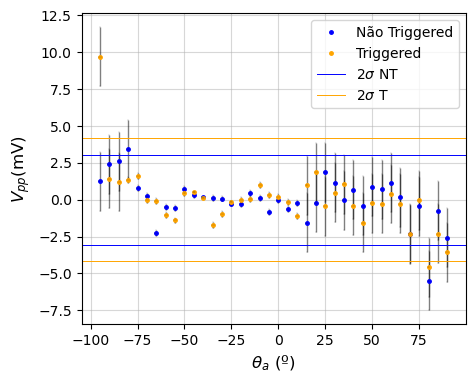

In [12]:
residuos_NT = data_NT[1] -mallus(data_NT[0],*coefs_NT)
residuos_T  = data_T[1] -mallus(data_T[0],*coefs_T)
residuos = [residuos_NT, residuos_T]

fig, ax=makeplot([data_NT[0], residuos_NT ], "Não Triggered", colors[0], erros_NT, bars =True)
add_points([data_T[0], residuos_T ], "Triggered", colors[1], [fig, ax], erros_T, bars =True)


for i in range(len(residuos)):
    print( "Média dos resíduos:",np.average(residuos[i]), "\t Resíduo máximo",np.max(np.abs(residuos[i])), "\t Desvio padrão:", np.std(residuos[i]))
    if i == 0:
        label = r'$2 \sigma$ NT'
    if i == 1:
        label = r'$2 \sigma$ T'
    ax.axhline(2*np.std(residuos[i]),ax.get_xlim()[0], ax.get_xlim()[1], color=colors[i], linestyle='solid', linewidth=0.7,  label = label)
    ax.axhline(-2*np.std(residuos[i]),ax.get_xlim()[0], ax.get_xlim()[1], color=colors[i], linestyle='solid', linewidth=0.7)


ax.legend()

In [13]:
theta_P , theta_A , V0 , a , V_off, beta ,dtheta= sp.symbols( "theta_P theta_A V_0 a V_{offset} beta Delta" )
VDPP               = sp.symbols( "V_{dpp}" , cls = sp.Function )
eq = sp.Eq( VDPP( theta_A ) , V0 * sp.cos( theta_A - theta_P + a ) ** 2 + V_off )
eq

Eq(V_{dpp}(theta_A), V_0*cos(a + theta_A - theta_P)**2 + V_{offset})

### Parte C

#### Dados

In [14]:
data = np.genfromtxt("CSVs/T9_1_C_NT_1.csv", delimiter = ",", skip_header=1)
data_NT1 = np.transpose(data[:, 0:2])
data_NT1[0] -= thetaP
erros_NT1 = np.transpose(data[:, 2:4])

data = np.genfromtxt("CSVs/T9_1_C_NT_2.csv", delimiter = ",", skip_header=1)
data_NT2 = np.transpose(data[:, 0:2])
data_NT2[0] -= thetaP
erros_NT2 = np.transpose(data[:, 2:4])

data = np.genfromtxt("CSVs/T9_1_C_NT_3.csv", delimiter = ",", skip_header=1)
data_NT3 = np.transpose(data[:, 0:2])
data_NT3[0] -= thetaP
erros_NT3 = np.transpose(data[:, 2:4])

data =  np.genfromtxt("CSVs/T9_1_C_T.csv", delimiter = ",", skip_header=1)
data_T = np.transpose(data[:, 0:2])
data_T[0] -= thetaP
erros_T = np.transpose(data[:, 2:4])

data = [data_NT1, data_NT2,data_NT3, data_T]
erros = [erros_NT1, erros_NT2,erros_NT3, erros_T]
labels = [ r"NT $\phi = 60º $",  r"NT $\phi = 40º $",  r"NT $\phi = 120º $",  r"T $\phi = 70º $"]
coefs = []
residuos = []

In [15]:
# --- Formatação da figura ---
cm          = 1/2.54  # centimeters in inches
figsize     = ( 12*cm, 10*cm )
dpi         = 100

# --- Texto que apareça no gráfico ---
fontsize        = 12
title           = "Lâmina"
xlabel          = r"$\theta_a-\theta_p$ (º)"
ylabel          = "$V_{dpp}$(mV)"

# --- Formação dos pontos ---
marker_type = "o"
markersize  = 2.5

# --- formatação da escala do gráfico ---
ticks = False
if ticks:
    xticks      = np.linspace( - 95 , 95 , 10 )
    yticks      = np.linspace( 70 , 275 , 10)

# --- Transparência da grid ---
alpha_grid = 0.5 

# --- Formatação barras de erro --- 
color_bars    = "k"
alpha_bars    = 0.5
thickness     = 1 
head_size     = 1 
head_thick    = 0.2 

# --- Informação para guardar a imagem ---
fig_name = "fig3" #sem o png!

#### Gráficos

In [16]:
val = V0 * ( sp.cos( dtheta ) ** 2 + sp.cos( 2 * beta - dtheta ) ** 2 )
eq1 = sp.Eq( VDPP( theta_A , dtheta ) , val  )
eq1 

Eq(V_{dpp}(theta_A, Delta), V_0*(cos(Delta)**2 + cos(Delta - 2*beta)**2))

Pode dar alguma ideia para os ajustes olhando para a expansão da fórmula 

In [17]:
sp.expand_trig( val )

V_0*(((2*cos(beta)**2 - 1)*cos(Delta) + 2*sin(Delta)*sin(beta)*cos(beta))**2 + cos(Delta)**2)

No handles with labels found to put in legend.


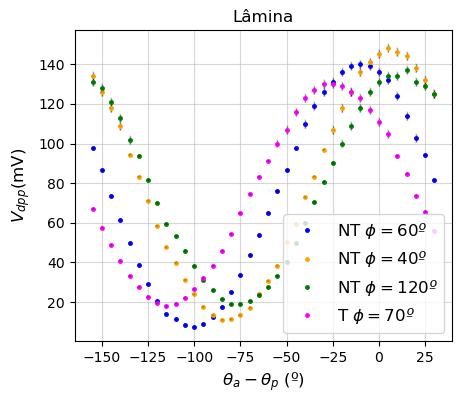

In [18]:
fig, ax = makeplot(data[0], labels[0], colors[0], erros[0], bars=True)
plt.title(title)

for i in range(1, len(data)):
    add_points(data[i], labels[i], colors[i], [fig,ax], erros[i], bars=True)

NT $\phi = 60º $
[79.15647481 71.36411049  0.03728854]
beta do ajuste:  79.15647480587553 

NT $\phi = 40º $
[97.29663042 70.07674511  0.1189666 ]
beta do ajuste:  97.2966304218921 

NT $\phi = 120º $
[103.17359732  65.42851505   0.17504206]
beta do ajuste:  103.17359732123718 

T $\phi = 70º $
[65.60378691 83.98361816 -0.11302241]
beta do ajuste:  65.60378691151031 



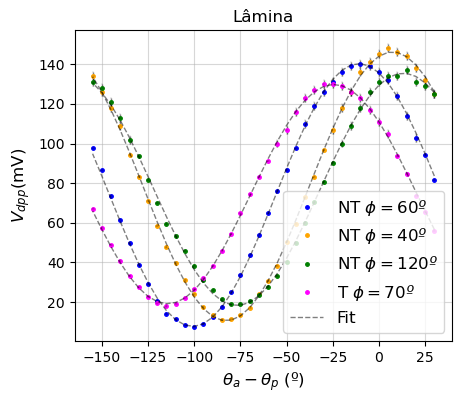

In [19]:
def fit(dtheta, beta, a,b):
    return a*(np.cos(np.radians(dtheta))**2+np.cos(np.radians(2*beta-dtheta))**2+ b)

coefs = []
residuos = []

for i in range(len(data)):
    coefs.append(get_coef(data[i][0], data[i][1], fit, [60,20,0]))
    print(labels[i])
    print(coefs[i])
    print("beta do ajuste: ", coefs[i][0], "\n")
    
coefs_NT1, coefs_NT2, coefs_NT3,coefs_T = coefs[0], coefs[1], coefs[2], coefs[3]

for i in range(len(data)):
    if i == 0:
        label = "Fit"
    else:
        label = False
    add_fit(ax, data[i][0], coefs[i], fit, label = label)

fig

No handles with labels found to put in legend.


NT $\phi = 60º $
Média dos resíduos: -1.200154034632449e-08 	 Resíduo máximo 2.787348875461589 	 Desvio padrão: 1.1234546090706665
NT $\phi = 40º $
Média dos resíduos: 2.7191550531681154e-09 	 Resíduo máximo 2.363223401405932 	 Desvio padrão: 1.1045815154077943
NT $\phi = 120º $
Média dos resíduos: 9.693615641176142e-09 	 Resíduo máximo 3.4419180232247086 	 Desvio padrão: 1.4378065066376227
T $\phi = 70º $
Média dos resíduos: 1.2801448322438534e-09 	 Resíduo máximo 2.154294934733173 	 Desvio padrão: 0.9143776297967688


Text(0.5, 1.0, 'Resíduos')

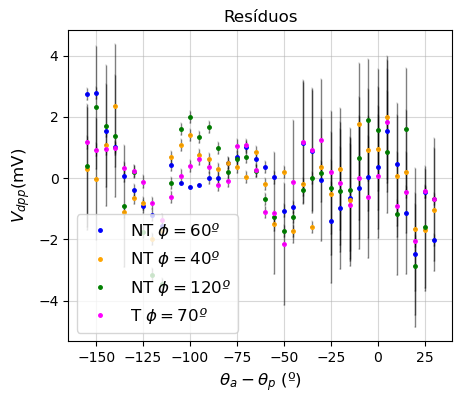

In [20]:
title="Resíduos"

for i in range(len(data)):
    residuos.append(data[i][1]-fit(data[i][0], *coefs[i]))

residuos_NT1, residuos_NT2, residuos_NT3, residuos_T = residuos[0], residuos[1], residuos[2], residuos[3]

fig, ax = makeplot([data[0][0], residuos[0]], labels[0], colors[0], erros[0], bars=True)
for i in range(1, len(data)):
    add_points([data[i][0], residuos[i]], labels[i], colors[i], [fig,ax], erros[i], bars=True)

for i in range(len(residuos)):
    print(labels[i])
    print( "Média dos resíduos:",np.average(residuos[i]), "\t Resíduo máximo",np.max(np.abs(residuos[i])), "\t Desvio padrão:", np.std(residuos[i]))

plt.title(title)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


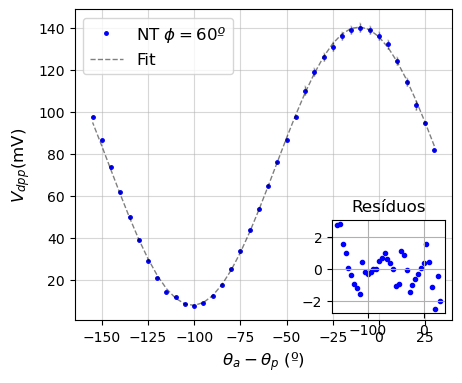

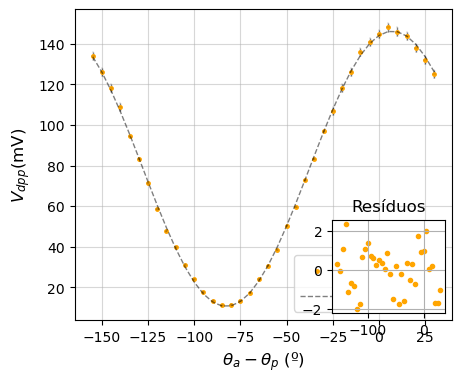

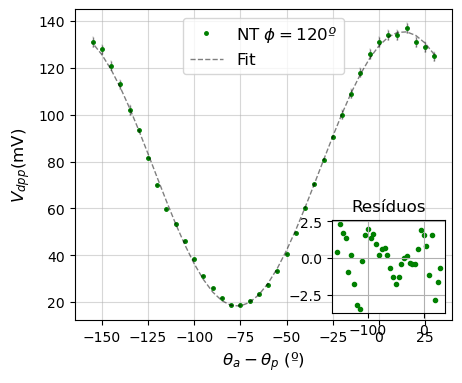

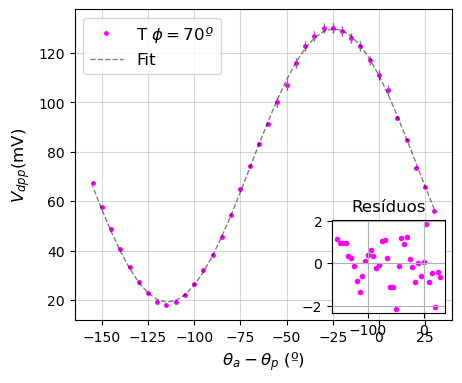

In [21]:
for i in range(len(data)):
    fig, ax = makeplot(data[i], labels[i], colors[i], erros[i], bars=True)
    add_fit(ax, data[i][0], coefs[i], fit)
    add_residues(data[i][0], fit(data[i][0],*coefs[i]), data[i][1], colors[i], True,fig, ax, 4)

## Segunda parte 

Data

In [24]:
Ls = np.genfromtxt("CSVs/T9_L.csv", delimiter = ",", skip_header=1)*10**(-2)
L, u_L = np.average(Ls), np.std(Ls)
print("Comprimento bloco, em metros:", L, "+/-", u_L)
z1 = 30 # cm

data = np.genfromtxt("CSVs/T9_2.csv", delimiter = ",", skip_header=1)

data_ar = np.transpose(data[:,0:2])
erros_ar = np.transpose(data[:, 3:5])
data_ar[0] -= z1

data_bloc = np.transpose(data[4:,1:3])
difs = data_bloc[0]-data_bloc[1]
data_bloc = [np.arange(1,len(data_bloc[0])+1),difs]
erros_bloc = np.transpose(data[4:, 4:7]) # fix this


f = 60*10**6
df = 0.1*10**6

Comprimento bloco, em metros: 0.50135 +/- 0.00022912878474776676


In [25]:
# --- Formatação da figura ---
cm          = 1/2.54  # centimeters in inches
figsize     = ( 12*cm, 10*cm )
dpi         = 100

# --- Texto que apareça no gráfico ---
fontsize        = 12
title           = "Velocidade da Luz"
xlabel          = r"$\Delta z$ (cm)"
ylabel          = "$\Delta \phi_{ar}$(º)"

# --- Formação dos pontos ---
marker_type = "o"
markersize  = 2.5

# --- formatação da escala do gráfico ---
ticks = False
if ticks:
    xticks      = np.linspace( - 95 , 95 , 10 )
    yticks      = np.linspace( 70 , 275 , 10)

# --- Transparência da grid ---
alpha_grid = 0.5 

# --- Formatação barras de erro --- 
color_bars    = "k"
alpha_bars    = 0.5
thickness     = 1 
head_size     = 1 
head_thick    = 0.2 

# --- Informação para guardar a imagem ---
fig_name = "fig3" #sem o png!

#### Ar

No handles with labels found to put in legend.


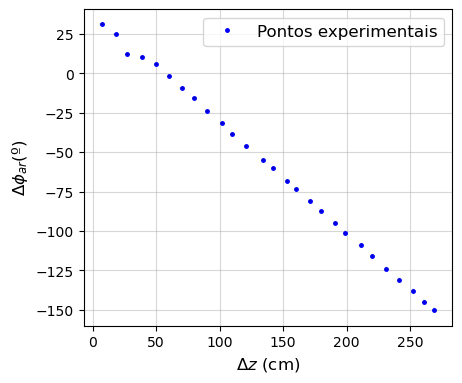

In [26]:
fig, ax = makeplot(data_ar, "Pontos experimentais", colors[0], erros_ar, bars= True)

coeficientes: 
 [-0.69757068 38.09464049]
1.2174905069337965
velocidade experimental:  309646043.46707636  +/-
erro relativo: (%) 3.2868023207829866


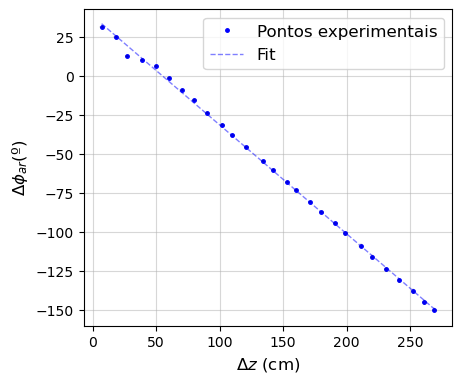

In [27]:
def get_coef( x , y , f_fit , coef0 ):
    result = spo.curve_fit( f_fit , x , y , p0 = coef0 )
    return result[ 0 ]

def linear(x,a,b):
    return a*x+b

coefs_ar = get_coef( data_ar[0] , data_ar[1] , linear , [1.75, 0] )

print("coeficientes: \n", coefs_ar)

declive_SI =  -1*coefs_ar[0]*10**(2)*np.pi/180
print(declive_SI)
speed_ar = 2*f*np.pi / declive_SI
c = 299792458
erro = np.abs(speed_ar - c)/c


print("velocidade experimental: ", speed_ar, " +/-" )
print("erro relativo: (%)", erro*100)
add_fit(ax, data_ar[0], coefs_ar, linear, label="Fit", linestyle = "b--")

fig

No handles with labels found to put in legend.


Média dos resíduos: -4.772821348019028e-09 	 Resíduo máximo 7.060232224151292 	 Desvio padrão: 1.7447847818654165


Text(0.5, 1.0, 'Resíduos')

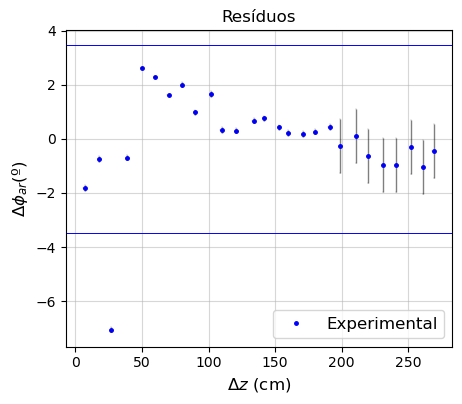

In [28]:
title="Resíduos"
residuos = data_ar[1]-linear(data_ar[0], *coefs_ar)

fig, ax = makeplot([data_ar[0], residuos], "Experimental", colors[0], erros_ar, bars=True)

print( "Média dos resíduos:",np.average(residuos), "\t Resíduo máximo",np.max(np.abs(residuos)), "\t Desvio padrão:", np.std(residuos))

ax.axhline(2*np.std(residuos),ax.get_xlim()[0], ax.get_xlim()[1], color=colors[0], linestyle='solid', linewidth=0.7,  label =r'$2 \sigma$')
ax.axhline(-2*np.std(residuos),ax.get_xlim()[0], ax.get_xlim()[1], color=colors[0], linestyle='solid', linewidth=0.7)

plt.title(title)

#### Acrilico

In [29]:
# --- Formatação da figura ---
cm          = 1/2.54  # centimeters in inches
figsize     = ( 12*cm, 10*cm )
dpi         = 100

# --- Texto que apareça no gráfico ---
fontsize        = 12
title           = "Velocidade da Luz"
xlabel          = r"Número da medição"
ylabel          = "$\Delta \phi_{ar} - \Delta \phi_{acrílico}$(º)"

# --- Formação dos pontos ---
marker_type = "o"
markersize  = 2.5

# --- formatação da escala do gráfico ---
ticks = False
if ticks:
    xticks      = np.linspace( - 95 , 95 , 10 )
    yticks      = np.linspace( 70 , 275 , 10)

# --- Transparência da grid ---
alpha_grid = 0.5 

# --- Formatação barras de erro --- 
color_bars    = "k"
alpha_bars    = 0.5
thickness     = 1 
head_size     = 1 
head_thick    = 0.2 

# --- Informação para guardar a imagem ---
fig_name = "fig3" #sem o png!

No handles with labels found to put in legend.


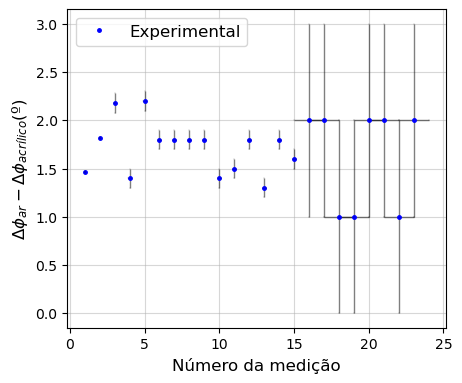

In [30]:
fig, ax = makeplot([data_bloc[0],data_bloc[1]], "Experimental", colors[0], erros_bloc, bars = True)

In [31]:
print( "Média das diferenças:",np.average(data_bloc[1]), "\t Máximo",np.max(np.abs(data_bloc[1])), "\t Desvio padrão:", np.std(data_bloc[1]))

dif_media = np.radians(np.average(data_bloc[1]))
ind_exp = dif_media/(L*declive_SI) + 1
print("índice de refração experimental:", ind_exp)
print("velocidade no acrílico experimental:", c/ind_exp)

Média das diferenças: 1.6808695652173908 	 Máximo 2.1999999999999993 	 Desvio padrão: 0.3559422650237618
índice de refração experimental: 1.048062325282274
velocidade no acrílico experimental: 286044494.4619654
